# The Impact of Ambient Temperature on Server Efficiency


Hypothesis: Server power consumption increases as temperature increases reducing server efficiency. As PUE values approach 1 an increasing portion of the Data centre's power is used in the server therfore there is likely to be a trade-off on operating temperature depending on cooling infrastructure and number of servers in the datacenter. 

------

Plan:

- Load in all of the SERT results avoiding any invalid ones
- Merge data as needed 
- Generate graphs showing power consumption against load and temperature
- Find a trade-off between operating temperature and number of servers. 


In [165]:
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from parse_results import process_results_xml
import yaml
#import influxdb_client

In [166]:
settings_file = Path('settings.yaml')

if settings_file.exists():
    with settings_file.open() as f:
        params = yaml.load(f, Loader=yaml.FullLoader)
else:
    params = {}
    
sert_results_dir = params.get('results_dir', 'sert_results')
bios_setting_file = params.get('test_settings', 'test_settings.csv')
cpu_metrics_dir = params.get('cpu_metrics_dir', 'cpu_data')

working_dir_path = params.get('temp_dir', 'temp_dir')
all_data_file = params.get('data_file', 'all_data.csv')
overwrite_data = params.get('overwrite_data', False)

whitelist = params.get('whitelist', '')

working_dir = Path(working_dir_path)

# Generate and load the data (Run Once)

In [167]:
def aggregate_sert(file, test_name, test_details, params):
    # Load the SERT result
    metrics, score, env = process_results_xml(f)
    
    # METRICS
    metrics_df = pd.DataFrame.from_records(metrics)
    # Remove calibration runs but record the calibration score against each loadlevel to calculate actual loadlevel
    calibrations = metrics_df.loc[metrics_df['loadlevel']=='calibration', ['worklet', 'score']]
    calibrations = calibrations.rename(columns={'score': 'calibration-score'})

    metrics_df = pd.merge(metrics_df.drop(index=calibrations.index), calibrations, how='left', on='worklet')
    metrics_df['actual-load'] = metrics_df['score'] / metrics_df['calibration-score']
    metrics_df.loc[metrics_df['workload'] == 'Idle', 'actual-load'] = 0
    metrics_df['test-name'] = test_name
    
    if test_details['location'].get(test_name) == 'Tunnel':
        if 'influxdb' in params:
            metrics_df['pressure'] = get_tunnel_pressure(metrics_df, params)
        else:
            # Can't get tunnel data without influx credentials
            metrics_df['pressure'] = np.nan
    else:
        metrics_df['pressure'] = 0.0

    # SCORE
    score_df = pd.DataFrame.from_records(score)
    score_df['test-name'] = test_name
    
    # ENV
    env_df = pd.DataFrame.from_records(env, index=[test_name])
    # Test details are "unknwon" if not in the test_details csv
    env_df['location'] = test_details['location'].get(test_name, 'unknown')
    env_df['bios'] = test_details['bios'].get(test_name, 'unknown')
    
    return metrics_df, env_df, score_df
    
def get_tunnel_pressure(metrics, params):
    from influxdb import InfluxDBClient
    client = InfluxDBClient(host=params['influxdb']['host'], 
                            port=params['influxdb']['port'], 
                            username=params['influxdb']['user'], 
                            password=params['influxdb']['password'],
                            database=params['influxdb']['tunnel-database'])
    
    return metrics.apply(get_pressure_row,  axis=1, client=client)
    
def get_pressure_row(r, client):
    query = f'select (mean("value")-21.65)*62/19 from sensors where "channel"=\'Pressure\' and time>=\'{r.start.isoformat()}\' and time<=\'{r.end.isoformat()}\''
    result = client.query(query)
    for pt in result.get_points('sensors'):
        return pt['mean']

    return np.nan # Tunnel run but no data    
    

# Ensure the working directory exists
if not working_dir.exists():
    working_dir.mkdir(parents=True)

# Temp files
metrics_path = working_dir.joinpath('metrics.csv')
scores_path = working_dir.joinpath('scores.csv')
details_path = working_dir.joinpath('test_details.csv')

    
# Load any existing chached data or start empty if they don't exist
if metrics_path.exists() and not overwrite_data:
    print('Loading SERT data from disk')
    try:
        metrics_data = pd.read_csv(str(metrics_path), parse_dates=['start', 'end'])
        scores = pd.read_csv(str(scores_path))
        test_details = pd.read_csv(str(details_path), index_col=0)
    except Exception as e:
        print('Reloading failed, exception: ', e, '\nRebuilding...')
        metrics_data = pd.DataFrame()
        test_details = pd.DataFrame()
        scores = pd.DataFrame()
else:
    print('Rebuilding SERT results data.....')
    metrics_data = pd.DataFrame()
    test_details = pd.DataFrame()
    scores = pd.DataFrame()

# Load external details for test
if bios_setting_file != '' and Path(bios_setting_file).is_file():
    settings = pd.read_csv(bios_setting_file, index_col=0)
else:
    raise Exception(f'Test scenario settings file not found. Cannot continue.')
    
# Find any results in the results directory that aren't already in the dataframes, but only look for results that are valid or in the whitelist
source_path = Path(sert_results_dir)
new_results = [source_path.joinpath(test).joinpath('results.xml') for test in settings.index if test not in test_details.index]

failed_files = []

for f in new_results:     
    try:
        metrics, details, score = aggregate_sert(str(f), f.parent.name, settings, params)

        metrics_data = metrics_data.append(metrics, ignore_index=True)
        test_details = test_details.append(details)
        scores = scores.append(score, ignore_index=True)

    except Exception as e:
        print(f.parent.name, ' FAILED TO LOAD -- ', e, type(e))
        failed_files += f.name

        
# Store the new metrics
if len(new_results) > 0:
    # Store generated data
    metrics_data.to_csv(str(metrics_path), index=False)
    test_details.to_csv(str(details_path))
    scores.to_csv(str(scores_path), index=False)

Loading SERT data from disk
sert-0064  FAILED TO LOAD --  The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all(). <class 'ValueError'>
sert-0064  FAILED TO LOAD --  The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all(). <class 'ValueError'>
sert-0167  FAILED TO LOAD --  'NoneType' object has no attribute 'find' <class 'AttributeError'>
sert-0207  FAILED TO LOAD --  'loadlevel' <class 'KeyError'>
sert-0242  FAILED TO LOAD --  'loadlevel' <class 'KeyError'>
sert-0248  FAILED TO LOAD --  [Errno 2] No such file or directory: 'C:\\Users\\s.clement\\Techbuyer Group\\Dan Burdett- Techbuyer Europe - Results - PowerEdge\\sert-0248\\results.xml' <class 'FileNotFoundError'>
sert-0254  FAILED TO LOAD --  [Errno 2] No such file or directory: 'C:\\Users\\s.clement\\Techbuyer Group\\Dan Burdett- Techbuyer Europe - Results - PowerEdge\\sert-0254\\results.xml' <class 'FileNotFoundError'>
sert-0255  FAILED TO LOAD --  [Errno 

In [168]:
# Set this to True if you haven't run the previous cell and want to just load the data from last time.
reload_from_cached = True

data_cache_path = working_dir.joinpath(all_data_file)

if reload_from_cached and data_cache_path.exists():
    sert_data = pd.read_csv(str(data_cache_path), parse_dates=['start', 'end'])
else:
    sert_data = pd.DataFrame(columns=['test-name'])

new_tests = test_details.index[~test_details.index.isin(sert_data['test-name'].unique())]

if len(new_tests) > 0:
    # Build the combined view for analysis

    # Join metrics, test details and scores into a big view table
    new_data = pd.merge(metrics_data[metrics_data['test-name'].isin(new_tests)], scores[['test-name', 'worklet', 'loadlevel', 'norm-score', 'ref-score', 'efficiency-score']], how='left', on=['test-name', 'worklet', 'loadlevel'])
    new_data = pd.merge(new_data, test_details, left_on='test-name', right_index=True)

    # Scenario column for easier display and filtering
    new_data['scenario'] = list(' - '.join(s) for s in zip(new_data['model'], new_data['cpu']))

    # Drop any tests that were run without hyperthreading
    new_data.drop(new_data[new_data.logical_cores == new_data.physical_cores].index, inplace=True)
    

    sert_data = sert_data.append(new_data)
    # Save a cache of the joins
    sert_data.to_csv(str(data_cache_path), index=False)

In [169]:
sert_data

,test-name,loadlevel,worklet,score,workload,watts-min,watts-max,watts-avg,start,end,...,psu,ref,vendor,location,bios,scenario,cpu-power,cpu-temp,cpu-load,cpu-freq
0,sert-0020,100%,Compress,3.062691e+04,CPU,443.60,459.90,453.219355,2021-07-20 17:09:13.563000+01:00,2021-07-20 17:10:14.073000+01:00,...,750.0,R620-HighP-MidT,Dell Inc.,Tunnel,Performance,PowerEdge R620 - Intel(R) Xeon(R) CPU E5-2690 ...,209.566667,76.844444,100.000000,3284.615
1,sert-0020,75%,Compress,2.303340e+04,CPU,394.53,399.82,396.494194,2021-07-20 17:10:26.424000+01:00,2021-07-20 17:11:26.680000+01:00,...,750.0,R620-HighP-MidT,Dell Inc.,Tunnel,Performance,PowerEdge R620 - Intel(R) Xeon(R) CPU E5-2690 ...,213.900000,71.688889,40.760417,3300.240
2,sert-0020,50%,Compress,1.536359e+04,CPU,336.89,341.17,338.587097,2021-07-20 17:11:39.005000+01:00,2021-07-20 17:12:39.239000+01:00,...,750.0,R620-HighP-MidT,Dell Inc.,Tunnel,Performance,PowerEdge R620 - Intel(R) Xeon(R) CPU E5-2690 ...,190.483333,69.655556,7.854167,3300.240
3,sert-0020,25%,Compress,7.655040e+03,CPU,282.27,285.81,283.971935,2021-07-20 17:12:50.569000+01:00,2021-07-20 17:13:50.798000+01:00,...,750.0,R620-HighP-MidT,Dell Inc.,Tunnel,Performance,PowerEdge R620 - Intel(R) Xeon(R) CPU E5-2690 ...,201.316667,68.644444,0.083333,3300.240
4,sert-0020,100%,CryptoAES,2.444161e+05,CPU,434.90,441.10,438.122581,2021-07-20 17:18:51.563000+01:00,2021-07-20 17:19:52.073000+01:00,...,750.0,R620-HighP-MidT,Dell Inc.,Tunnel,Performance,PowerEdge R620 - Intel(R) Xeon(R) CPU E5-2690 ...,172.033333,73.933333,85.714286,3300.240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13434,sert-0524,Flood_Full,Flood3,5.005347e+01,Memory,436.30,450.40,444.160000,2021-10-21 08:33:02.639000+01:00,2021-10-21 08:34:34.761000+01:00,...,750.0,R620-E52690-750W-Perf_BIOS,Dell Inc.,Tunnel,Performance,PowerEdge R620 - Intel(R) Xeon(R) CPU E5-2690 ...,NaN,NaN,NaN,NaN
13435,sert-0524,Flood_Half,Flood3,5.025802e+01,Memory,416.20,423.00,420.020000,2021-10-21 08:34:51.773000+01:00,2021-10-21 08:35:38.424000+01:00,...,750.0,R620-E52690-750W-Perf_BIOS,Dell Inc.,Tunnel,Performance,PowerEdge R620 - Intel(R) Xeon(R) CPU E5-2690 ...,NaN,NaN,NaN,NaN
13436,sert-0524,Capacity3_Base,Capacity3,6.745099e+05,Memory,429.00,453.80,440.912903,2021-10-21 08:43:42.885000+01:00,2021-10-21 08:44:43.522000+01:00,...,750.0,R620-E52690-750W-Perf_BIOS,Dell Inc.,Tunnel,Performance,PowerEdge R620 - Intel(R) Xeon(R) CPU E5-2690 ...,NaN,NaN,NaN,NaN
13437,sert-0524,Capacity3_Max,Capacity3,1.863167e+06,Memory,453.10,455.00,453.790323,2021-10-21 08:44:59.664000+01:00,2021-10-21 08:45:59.907000+01:00,...,750.0,R620-E52690-750W-Perf_BIOS,Dell Inc.,Tunnel,Performance,PowerEdge R620 - Intel(R) Xeon(R) CPU E5-2690 ...,NaN,NaN,NaN,NaN


In [170]:
#test_details
total_score = scores[scores['workload'] == 'All'].dropna(axis=1)
total_score = total_score.merge(test_details, left_on='test-name', right_index=True, how='left').dropna()
total_score['scenario'] = list(' - '.join(x) for x in zip(total_score['model'], total_score['cpu']))
total_score['temperature'] = total_score.apply(lambda row: sert_data[sert_data['test-name'] == row['test-name']]['temp-avg'].mean(), axis=1)
total_score['temperature-range'] = total_score.apply(lambda row: sert_data[sert_data['test-name'] == row['test-name']]['temp-max'].max() - sert_data[sert_data['test-name'] == row['test-name']]['temp-min'].min(), axis=1)
total_score = total_score.merge(sert_data[sert_data['workload'] == 'Idle'][['watts-avg','test-name']], left_on='test-name', right_on='test-name').rename(columns={'watts-avg':'idle-power'})
total_score['max-power'] = total_score.apply(lambda row: sert_data[(sert_data['test-name'] == row['test-name']) & (sert_data['loadlevel']=='100%')]['watts-avg'].mean(), axis=1)
total_score['pressure'] = total_score.apply(lambda row: sert_data[sert_data['test-name'] == row['test-name']]['pressure'].mean(), axis=1)
total_score['pressure_bound'] = pd.cut(total_score.pressure, [total_score.pressure.min(), 15, total_score.pressure.max()], labels=['low','high'])
total_score

,workload,efficiency-score,test-name,cpu,dimm_size_mb,dimms,hostname,logical_cores,model,numa_nodes,...,vendor,location,bios,scenario,temperature,temperature-range,idle-power,max-power,pressure,pressure_bound
0,All,8.920446,sert-0020,Intel(R) Xeon(R) CPU E5-2690 0 @ 2.90GHz,8192,8,R620-1,32,PowerEdge R620,2,...,Dell Inc.,Tunnel,Performance,PowerEdge R620 - Intel(R) Xeon(R) CPU E5-2690 ...,21.685482,0.3125,224.993607,376.521255,30.230610,high
1,All,8.953276,sert-0021,Intel(R) Xeon(R) CPU E5-2690 0 @ 2.90GHz,8192,8,R620-1,32,PowerEdge R620,2,...,Dell Inc.,Tunnel,Performance,PowerEdge R620 - Intel(R) Xeon(R) CPU E5-2690 ...,21.511090,0.3125,224.660164,374.651764,30.249636,high
2,All,8.928965,sert-0022,Intel(R) Xeon(R) CPU E5-2690 0 @ 2.90GHz,8192,8,R620-1,32,PowerEdge R620,2,...,Dell Inc.,Tunnel,Performance,PowerEdge R620 - Intel(R) Xeon(R) CPU E5-2690 ...,21.369713,0.3125,224.571148,375.715063,30.212243,high
3,All,8.947380,sert-0023,Intel(R) Xeon(R) CPU E5-2690 0 @ 2.90GHz,8192,8,R620-1,32,PowerEdge R620,2,...,Dell Inc.,Tunnel,Performance,PowerEdge R620 - Intel(R) Xeon(R) CPU E5-2690 ...,21.262872,0.2500,224.413115,374.851773,30.255844,high
4,All,8.953668,sert-0024,Intel(R) Xeon(R) CPU E5-2690 0 @ 2.90GHz,8192,8,R620-1,32,PowerEdge R620,2,...,Dell Inc.,Tunnel,Performance,PowerEdge R620 - Intel(R) Xeon(R) CPU E5-2690 ...,21.175232,0.2500,225.020984,374.474790,30.259437,high
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325,All,18.335910,sert-0516,Intel(R) Xeon(R) Gold 6148 CPU @ 2.40GHz,8192,8,WIN-47K2HVKE78P,80,PowerEdge R640,4,...,Dell Inc.,Tunnel,Performance,PowerEdge R640 - Intel(R) Xeon(R) Gold 6148 CP...,20.335589,0.1875,220.196970,401.506794,2.485188,low
326,All,8.713807,sert-0521,Intel(R) Xeon(R) CPU E5-2690 0 @ 2.90GHz,8192,8,R620-1,32,PowerEdge R620,2,...,Dell Inc.,Tunnel,Performance,PowerEdge R620 - Intel(R) Xeon(R) CPU E5-2690 ...,20.296468,0.3750,241.800000,383.646675,2.278887,low
327,All,8.715703,sert-0522,Intel(R) Xeon(R) CPU E5-2690 0 @ 2.90GHz,8192,8,R620-1,32,PowerEdge R620,2,...,Dell Inc.,Tunnel,Performance,PowerEdge R620 - Intel(R) Xeon(R) CPU E5-2690 ...,20.190579,0.2500,237.557049,383.174533,2.279676,low
328,All,8.718956,sert-0523,Intel(R) Xeon(R) CPU E5-2690 0 @ 2.90GHz,8192,8,R620-1,32,PowerEdge R620,2,...,Dell Inc.,Tunnel,Performance,PowerEdge R620 - Intel(R) Xeon(R) CPU E5-2690 ...,20.147253,0.3750,240.813770,383.885717,2.258340,low


In [171]:
import traceback

def read_coretemp_csv(filepath):
    #Read the file
    samples = pd.read_csv(filepath, skiprows=8, header=0, index_col=0, parse_dates=['Time'], encoding='cp1252')
    if not pd.api.types.is_datetime64_any_dtype(samples.index.dtype):
        # Final row contains "Session end:"
        samples.drop('Session end:', inplace=True)
        samples.index = pd.to_datetime(samples.index)

    summary = pd.DataFrame()
    summary['cpu-power'] = samples['CPU 0 Power'] + samples['CPU 1 Power']
    summary['avg-temp'] = samples.filter(regex='Temp').mean(axis=1, skipna=True)
    summary['avg-load'] = samples.filter(regex='load').mean(axis=1, skipna=True)
    summary['avg-freq'] = samples.filter(regex='speed').mean(axis=1, skipna=True)
    summary['source'] = filepath.name

    return summary

def read_ohwm_csv(filepath):
    cpu_metrics = pd.read_csv(filepath, header=[0,1], parse_dates=[0], index_col=0)
    cpu_metrics.columns = cpu_metrics.columns.get_level_values(0)

    #If the column isn't automatically converted then the CSV has been corrupted some how, 
    # try to recover as much data as possible by dropping any row where the time cannot be 
    # parsed (this might leave some columns with empty values in the preceeding row)
    cpu_metrics['Time'] = cpu_metrics.index
    cpu_metrics['Time'] = pd.to_datetime(cpu_metrics['Time'], errors='coerce')
    cpu_metrics.dropna(inplace=True)
    cpu_metrics.set_index('Time', inplace=True)
        
    
    summary = pd.DataFrame()

    summary['avg-temp'] = cpu_metrics.filter(regex='cpu/./temp').mean(axis=1, skipna=True)
    summary['avg-load'] = cpu_metrics.filter(regex='cpu/./load').mean(axis=1, skipna=True)
    summary['avg-freq'] = cpu_metrics.filter(regex='cpu/./clock').mean(axis=1, skipna=True)
    summary['cpu-power'] = cpu_metrics.filter(regex='cpu/./power/0').sum(axis=1) # cpu-package power
    summary['source'] = filepath.name
    return summary


cpu_metrics_file = working_dir.joinpath('cpu_metrics.csv')

if not cpu_metrics_file.exists() or overwrite_data:
    cpu_summary = pd.DataFrame(columns=['avg-temp', 'avg-load', 'avg-freq', 'cpu-power', 'source'])
else:
    print('Reading stored metrics...')
    cpu_summary = pd.read_csv(cpu_metrics_file, index_col='Time', parse_dates=['Time'])

if 'source' not in cpu_summary.columns:
    cpu_summary['source'] = ''

new_data = False
previous_files = cpu_summary['source'].unique()

# old format
for f in [file for file in Path(cpu_metrics_dir).glob('*.csv') if file.name not in previous_files]:
    try:
        print(f)
        cpu_summary = cpu_summary.append(read_coretemp_csv(f))
        new_data = True
    except Exception as e:
        print(f'FAILED LOADING FILE: {f} -- {e}')
        continue


# new format
for f in [file for file in Path(cpu_metrics_dir).joinpath('ohwm').glob('*.csv') if file.name not in previous_files]:
    try:
        print(f)
        cpu_summary = cpu_summary.append(read_ohwm_csv(f))
        new_data = True
    except Exception as e:
        print(f'FAILED LOADING FILE: {f} -- {e}')
        continue    

cpu_summary.sort_index(inplace=True)
cpu_summary.index.name = 'Time'

if new_data:
    print('Saving new CSV')
    cpu_summary.to_csv(cpu_metrics_file)
    

Reading stored metrics...


In [172]:

#pd.to_datetime(cpu_metrics['Time']
if 'cpu-power' not in sert_data.columns:
    sert_data = sert_data.reindex(columns= sert_data.columns.tolist() + ['cpu-power', 'cpu-temp', 'cpu-load', 'cpu-freq'])

mask = sert_data['cpu-power'].isna()

print(f'Filling {mask.sum()} runs')

sert_data.loc[mask, 'cpu-power'] = sert_data.loc[mask, :].apply(lambda row: cpu_summary['cpu-power'][row['start']:row['end']].mean(), axis=1)

sert_data.loc[mask, 'cpu-temp'] = sert_data.loc[mask, :].apply(lambda row: cpu_summary['avg-temp'][row['start'].tz_localize(None):row['end'].tz_localize(None)].mean(), axis=1)
sert_data.loc[mask, 'cpu-load'] = sert_data.loc[mask, :].apply(lambda row: cpu_summary['avg-load'][row['start'].tz_localize(None):row['end'].tz_localize(None)].mean(), axis=1)
sert_data.loc[mask, 'cpu-freq'] = sert_data.loc[mask, :].apply(lambda row: cpu_summary['avg-freq'][row['start'].tz_localize(None):row['end'].tz_localize(None)].mean(), axis=1)

if mask.any():
    sert_data.to_csv(str(data_cache_path), index=False)

Filling 924 runs


<ipython-input-172-14440a8327dc>:9: FutureWarning: Indexing a timezone-naive DatetimeIndex with a timezone-aware datetime is deprecated and will raise KeyError in a future version.  Use a timezone-naive object instead.
  sert_data.loc[mask, 'cpu-power'] = sert_data.loc[mask, :].apply(lambda row: cpu_summary['cpu-power'][row['start']:row['end']].mean(), axis=1)


In [173]:
sert_data.describe()

,score,watts-min,watts-max,watts-avg,temp-min,temp-max,temp-avg,calibration-score,actual-load,pressure,...,dimm_size_mb,dimms,logical_cores,numa_nodes,physical_cores,psu,cpu-power,cpu-temp,cpu-load,cpu-freq
count,1.343900e+04,13439.000000,13439.000000,13439.000000,13439.000000,13439.000000,13439.000000,1.180200e+04,12132.000000,13106.000000,...,13439.0,13439.0,13439.000000,13439.000000,13439.000000,13439.0,12515.000000,12767.000000,12767.000000,12767.000000
mean,4.441140e+05,247.292034,254.738524,250.558095,23.633939,23.678129,23.656769,5.899789e+05,0.608129,10.128220,...,8192.0,8.0,54.899918,3.548478,21.840911,750.0,129.084948,59.557652,36.863640,2223.481982
std,9.159859e+05,99.460432,101.803502,100.675774,2.701487,2.703410,2.702505,9.318129e+05,0.297171,11.875285,...,0.0,0.0,16.439257,0.836196,2.736749,0.0,140.053619,12.652169,36.383863,697.213629
min,0.000000e+00,67.550000,69.590000,68.368525,17.437500,17.562500,17.471154,1.922230e+02,0.000000,-9.341460,...,8192.0,8.0,32.000000,2.000000,16.000000,750.0,0.000000,23.107762,0.000000,744.404006
25%,7.633111e+03,177.790000,182.640000,180.469212,21.000000,21.000000,21.000000,3.621772e+04,0.374073,0.871108,...,8192.0,8.0,48.000000,4.000000,20.000000,750.0,77.094253,51.501737,3.803751,1902.106786
50%,6.108815e+04,225.020000,229.090000,226.820000,23.500000,23.562500,23.557500,1.123830e+05,0.503219,2.493174,...,8192.0,8.0,48.000000,4.000000,24.000000,750.0,111.683177,61.155769,23.358115,2217.864710
75%,3.426975e+05,317.300000,327.785000,322.157742,26.000000,26.062500,26.003203,4.133753e+05,0.876180,24.978459,...,8192.0,8.0,80.000000,4.000000,24.000000,750.0,180.879753,69.100000,76.469825,2883.199167
max,6.662897e+06,494.800000,509.500000,501.846825,30.562500,30.687500,30.642857,3.071580e+06,1.058154,32.210291,...,8192.0,8.0,80.000000,4.000000,24.000000,750.0,7002.095378,83.379684,100.000000,3325.237096


In [174]:
sert_data.head()    

,test-name,loadlevel,worklet,score,workload,watts-min,watts-max,watts-avg,start,end,...,psu,ref,vendor,location,bios,scenario,cpu-power,cpu-temp,cpu-load,cpu-freq
13434,sert-0524,Flood_Full,Flood3,5.005347e+01,Memory,436.30,450.40,444.160000,2021-10-21 08:33:02.639000+01:00,2021-10-21 08:34:34.761000+01:00,...,750.0,R620-E52690-750W-Perf_BIOS,Dell Inc.,Tunnel,Performance,PowerEdge R620 - Intel(R) Xeon(R) CPU E5-2690 ...,NaN,NaN,NaN,NaN
13435,sert-0524,Flood_Half,Flood3,5.025802e+01,Memory,416.20,423.00,420.020000,2021-10-21 08:34:51.773000+01:00,2021-10-21 08:35:38.424000+01:00,...,750.0,R620-E52690-750W-Perf_BIOS,Dell Inc.,Tunnel,Performance,PowerEdge R620 - Intel(R) Xeon(R) CPU E5-2690 ...,NaN,NaN,NaN,NaN
13436,sert-0524,Capacity3_Base,Capacity3,6.745099e+05,Memory,429.00,453.80,440.912903,2021-10-21 08:43:42.885000+01:00,2021-10-21 08:44:43.522000+01:00,...,750.0,R620-E52690-750W-Perf_BIOS,Dell Inc.,Tunnel,Performance,PowerEdge R620 - Intel(R) Xeon(R) CPU E5-2690 ...,NaN,NaN,NaN,NaN
13437,sert-0524,Capacity3_Max,Capacity3,1.863167e+06,Memory,453.10,455.00,453.790323,2021-10-21 08:44:59.664000+01:00,2021-10-21 08:45:59.907000+01:00,...,750.0,R620-E52690-750W-Perf_BIOS,Dell Inc.,Tunnel,Performance,PowerEdge R620 - Intel(R) Xeon(R) CPU E5-2690 ...,NaN,NaN,NaN,NaN
13438,sert-0524,idle,Idle,0.000000e+00,Idle,240.39,243.88,241.580164,2021-10-21 08:51:35.440000+01:00,2021-10-21 08:53:10.700000+01:00,...,750.0,R620-E52690-750W-Perf_BIOS,Dell Inc.,Tunnel,Performance,PowerEdge R620 - Intel(R) Xeon(R) CPU E5-2690 ...,NaN,NaN,NaN,NaN


# What scenarios have been tested?
Using a 3 bin strategy for temperature testing and high and low for pressure.

In [175]:
total_score.drop(total_score.index[total_score.pressure.isnull()], inplace=True)

tested = total_score.groupby(['scenario', 'bios', 'pressure_bound', pd.cut(total_score.temperature,[20, 23.3,26.6, 30])]).size().unstack().unstack()
tested.style.applymap(lambda x: 'background-color:pink' if x < 3 else None)

Mean
 scenario
PowerEdge R620 - Intel(R) Xeon(R) CPU E5-2690 0 @ 2.90GHz      23.673865
PowerEdge R620 - Intel(R) Xeon(R) CPU E5-2690 v2 @ 3.00GHz     21.759720
PowerEdge R630 - Intel(R) Xeon(R) CPU E5-2690 v3 @ 2.60GHz     21.570111
PowerEdge R640 - Intel(R) Xeon(R) Gold 6148 CPU @ 2.40GHz      22.947705
PowerEdge R640 - Intel(R) Xeon(R) Silver 4116 CPU @ 2.10GHz    24.326037
Name: temp-avg, dtype: float64

Variance
 scenario
PowerEdge R620 - Intel(R) Xeon(R) CPU E5-2690 0 @ 2.90GHz      6.235563
PowerEdge R620 - Intel(R) Xeon(R) CPU E5-2690 v2 @ 3.00GHz     0.835946
PowerEdge R630 - Intel(R) Xeon(R) CPU E5-2690 v3 @ 2.60GHz     1.265041
PowerEdge R640 - Intel(R) Xeon(R) Gold 6148 CPU @ 2.40GHz      7.643790
PowerEdge R640 - Intel(R) Xeon(R) Silver 4116 CPU @ 2.10GHz    6.973601
Name: temp-avg, dtype: float64


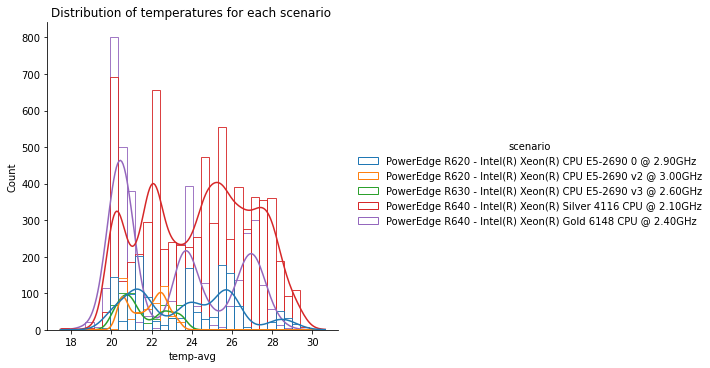

In [177]:
print('Mean\n', sert_data.groupby('scenario')['temp-avg'].mean())
print('\nVariance\n', sert_data.groupby('scenario')['temp-avg'].var())
sns.displot(data=sert_data, x="temp-avg", hue="scenario", kde=True, fill=False).set_title('Distribution of temperatures for each scenario ')

C:\Users\s.clement\Miniconda3\envs\data-analysis\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


AttributeError: 'FacetGrid' object has no attribute 'set_title'

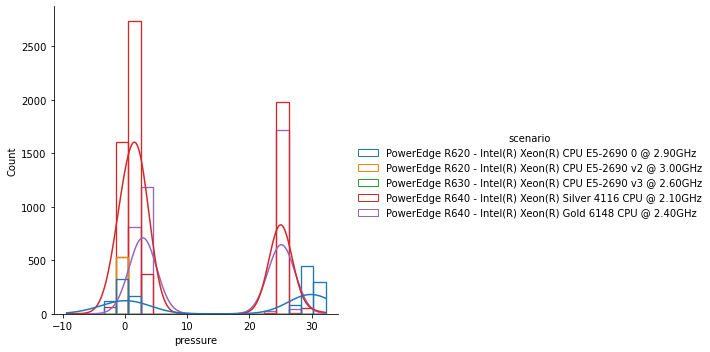

In [ ]:
sns.displot(data=sert_data, x="pressure", hue="scenario", kde=True, fill=False).set_title('Distribution of differential pressure for each scenario ')

# Effects on overall SERT score

# Efficiency and power consumption measured by SERT

For the CPU workelts in particular, we can plot the benchmark load against the efficiency score achevied for each scenario. 

In [ ]:
cpu = sert_data[(sert_data['workload'] == 'CPU')| (sert_data['workload'] == 'Idle')]

sns.lmplot(x='actual-load', y='efficiency-score', hue='scenario', col='bios', 
           data=cpu[cpu['temp-avg'] < 23.66], order=2, truncate=True, scatter=True).fig.suptitle('CPU Worklet Efficiency Scores', y=1.1)
sns.lmplot(x='actual-load', y='watts-avg', hue='scenario', col='bios', 
           data=cpu[cpu['temp-avg'] < 23.66], order=2, truncate=True, scatter=True).fig.suptitle('CPU Worklet Power Consumption', y=1.1)

A cleaner plot without the individual data plotted for each sert run. 

In [ ]:
sns.lmplot(x='actual-load', y='efficiency-score', hue='scenario', data=cpu[cpu['temp-avg'] < 23.66], order=2, truncate=True, scatter=False)
ax = plt.gca()
ax.set_title('CPU Worklet Efficiency Scores ( Test Temperature < 23.66C)')

The environmental conditions for the tests are as follows:

# The Effect of Temperature
The overall efficiency score across various temperatures

In [ ]:
sns.lmplot(data=total_score, x='temperature', y='efficiency-score', hue='bios', col='pressure_bound', row='scenario')

In [ ]:
print(sert_data.shape , pd.cut(sert_data['temp-avg'],[20, 23.3,26.6, 30]).size)
tempdf = sert_data[(sert_data.workload == 'CPU') & (sert_data.pressure < 15) & (sert_data.cpu == 'Intel(R) Xeon(R) Gold 6148 CPU @ 2.40GHz')].copy()
tempdf['loadlevel'] = tempdf['loadlevel'].apply(lambda x: float(x.strip('%')) / 100)
tempdf.groupby(['loadlevel', pd.cut(tempdf['temp-avg'],[20, 23.3,26.6, 30])])['watts-avg'].mean().unstack().pct_change(axis=1).plot()


In [ ]:
total_score[total_score['temperature'] < 22].groupby(['scenario', 'bios'])[['efficiency-score', 'temperature', 'idle-power', 'max-power']].mean()


In [ ]:
total_score[total_score['temperature'] > 28].groupby(['scenario', 'bios'])[['efficiency-score', 'temperature', 'idle-power', 'max-power']].mean()

In [ ]:
cpu[(cpu['loadlevel'] == '100%')].groupby([ 'worklet','scenario', 'bios'])['norm-score'].mean().unstack().pct_change(axis=1).abs().mean()

In [ ]:
cpu[(cpu.model == 'PowerEdge R640') & (cpu.worklet == 'CryptoAES') & (cpu.loadlevel == '100%')].groupby('bios')['norm-score'].mean()

In [ ]:
cpu[['worklet', 'loadlevel', 'scenario', 'bios', 'score']].groupby(['scenario', 'bios', 'worklet', 'loadlevel']).mean()

# CPU Power

The CPU is usually considered the driver of most power consumption in the server (excluding any expansion cards). During the SERT tests we have also recorded low-level performance registers of the CPU like per-core frequency and also power consumption. 

Todo: 
- Determine relationship between chassis and CPU power consumption
    - Assume power = P_Idle + P_Chassis + P_CPU
    - IS P_Chassis a function of CPU power?
    
    
Read the CPU power data in and summarise for the tests

In [ ]:
cpu_summary.drop(cpu_summary.index[cpu_summary['cpu-power'] > 1000], inplace=True)
#print(cpu_summary.index[cpu_summary['cpu-power'] > 1000])
cpu_summary.plot.line()

In [ ]:
cpu_summary.head()

In [ ]:
cpu_summary.tail()

Looking again at the server efficiency scores, but now using the CPU utilsiation dat from the OS rather than the load data calculated by SERT. SERT load is a proportion of the total score/transactions acheived during the calibration runs. OS CPU utilisaiton is the proportion of time the CPU is busy performing operations. 

In [ ]:
cpu_worklets = sert_data[((sert_data['workload'] == 'Idle') | (sert_data['workload'] == 'CPU')) & (sert_data['bios'] != 'unknown')]
cpu_worklets['scenario'] = list(' - '.join(x) for x in zip(cpu_worklets['model'], cpu_worklets['cpu']))
sns.lmplot(x='cpu-load', y='efficiency-score', hue='scenario', col='pressure-bound', row='bios', data=cpu_worklets[cpu_worklets['temp-avg'] < 30], order=2, truncate=True, scatter=True).fig.suptitle('Efficiency Scores ( Test Temperature < 30C)', y=1.1)


In [ ]:
temperature = 30
sns.lmplot(x='cpu-load', y='efficiency-score', col='cpu', hue='bios', data=cpu_worklets[cpu_worklets['temp-avg'] < temperature], order=2, truncate=True, scatter=False).fig.suptitle(f'Efficiency Scores ( Test Temperature < {temperature}C)', y=1.1)

This is a significantly different relationship than that shown for the SERT load. 

Breaking down the performance per server and per worklet.

In [ ]:

    sns.lmplot(x='cpu-load', y='watts-avg', hue='worklet', col='bios', row='scenario', data=cpu_worklets, order=2, truncate=True, scatter=True).fig.suptitle(f'Efficiency Scores', y=1.1)


In [ ]:
sns.lmplot(x='temp-avg', y='efficiency-score', hue='scenario', data=cpu_worklets, order=1, scatter=False)

# CPU power consumption

In [ ]:
plotdf = cpu_worklets.melt('actual-load', ['watts-avg', 'cpu-power', 'chassis-power'])

sns.lmplot(x='actual-load', y='value', hue='variable', data=plotdf, order=2)

In [ ]:
for server in cpu_worklets['scenario'].unique():
    plotdf = cpu_worklets[cpu_worklets['scenario'] == server].melt(['actual-load', 'bios'], ['watts-avg', 'cpu-power', 'chassis-power'])

    sns.lmplot(x='actual-load', y='value', col='bios', hue='variable', data=plotdf, order=2).fig.suptitle(f'Power Breakdown - {server}', y=1.1)

In [ ]:
for server in cpu_worklets['scenario'].unique():
    plotdf = cpu_worklets[cpu_worklets['scenario'] == server].melt(['cpu-load', 'bios'], ['watts-avg', 'cpu-power', 'chassis-power'])

    sns.lmplot(x='actual-load', y='value', col='bios', hue='variable', data=plotdf, order=2).fig.suptitle(f'Power Breakdown - {server}', y=1.1)

In [ ]:
for worklet in sert_data[sert_data['workload'] == 'CPU']['worklet'].unique():
    sns.lmplot(data=sert_data[(sert_data['worklet'] == worklet) | (sert_data['workload'] == 'Idle')], x='actual-load', y='cpu-load', hue='scenario', col='bios', order=2).fig.suptitle(f'Server load vs CPU utilisaiton - {worklet}', y=1.1)

In [ ]:
cpu = sert_data[(sert_data['workload'] == 'CPU')| (sert_data['workload'] == 'Idle')]
cpu = cpu[cpu['model'] == 'PowerEdge R620']
#cpu = cpu[cpu['cpu'].str.contains('E5-2690 0')]


#sns.lmplot(x='cpu-power', y='chassis-power', hue='worklet', data=cpu, order=2)
sns.scatterplot(x='temp-avg', y='watts-avg', hue='cpu', data=cpu)

In [ ]:
sns.lmplot(x='cpu-load', y='cpu-power', data=cpu, order=2)

In [ ]:
ax = plt.scatter(x=cpu['cpu-temp'], y=cpu['cpu-power'], c=cpu['temp-avg'])
cbar = plt.colorbar()
cbar.ax.set_ylabel('Ambient Temp', rotation=90)
plt.ylabel('CPU Power')
plt.xlabel('CPU Temp')
plt.title('R620 E5-2690, Efficiency (DPAC) Mode')

In [ ]:
ax = plt.scatter(x=cpu['cpu-temp'], y=cpu['cpu-power'], c=cpu['cpu-load'])
cbar = plt.colorbar()
cbar.ax.set_ylabel('CPU Load', rotation=90)
plt.ylabel('CPU Power')
plt.xlabel('CPU Temp')
plt.title('R620 E5-2690, Efficiency (DPAC) Mode')

In [ ]:
ax = plt.scatter(x=cpu['cpu-freq'], y=cpu['cpu-power'], c=cpu['cpu-load'])
cbar = plt.colorbar()
cbar.ax.set_ylabel('CPU Load', rotation=90)
plt.ylabel('CPU Power')
plt.xlabel('CPU Freq')
plt.title('R620 E5-2690, Efficiency (DPAC) Mode')